# Processa os arquivos

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install gsw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.9 MB/s eta 0:00:00


In [9]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import gsw

# Define the path to the folder where the files are located on Google Drive
pasta_dados = '/content/drive/MyDrive/Artigo_AIA/Diferencas_TS/Dados_SSP_e_Hist'

# Uses the glob library to get all NetCDF files in the folder
arquivos = glob.glob(os.path.join(pasta_dados, '*.nc'))

# Filters the files to include only those with "historical" in the name
arquivos_hist = [arquivo for arquivo in arquivos if "historical" in arquivo]

# Defines the path to the folder where the difference files will be saved
pasta_resultados = '/content/drive/MyDrive/Artigo_AIA/Diferencas_TS/Diferenças_Cenarios'

# Creates the results folder if it does not exist
os.makedirs(pasta_resultados, exist_ok=True)

# Chooses the desired latitudes
latitudes = [-40, -30, -20, -10, -5]

def sal_min(ds):
    idxmin_lev = ds['sa'].argmin(dim='lev')
    sa_min = ds['sa'].min(dim='lev')
    thetao_at_sa_min = ds['thetao'].isel(lev=idxmin_lev)
    lev_at_sa_min = ds['lev'].isel(lev=idxmin_lev)
    sigma0 = gsw.sigma0(sa_min, thetao_at_sa_min)
    return sa_min, thetao_at_sa_min, lev_at_sa_min, sigma0

def encontrar_arquivo_ssp(arquivo_hist, cenario):
    partes = os.path.splitext(os.path.basename(arquivo_hist))[0].split('.')
    modelo_nome1 = partes[1]
    modelo_nome2 = partes[2]
    experimento = partes[3]

    # Constructs the path to the corresponding SSP file
    arquivo_ssp = os.path.join(pasta_dados, f'ScenarioMIP.{modelo_nome1}.{modelo_nome2}.{cenario}.Omon.gn.nc')

    return arquivo_ssp

def processar_modelo(arquivo_hist, arquivo_ssp, latitudes, cenario):
    modelo = os.path.splitext(os.path.basename(arquivo_hist))[0].split('.')[2]

    resultados = []

    for lat in latitudes:
        ds_hist = xr.open_dataset(arquivo_hist)
        ds_ssp = xr.open_dataset(arquivo_ssp)

        levels = np.arange(100, 1500, 1)
        ds_hist = ds_hist.interp(lev=levels, method="linear")
        ds_ssp = ds_ssp.interp(lev=levels, method="linear")

        sa_hist, t_hist, lev_hist, sigma_hist = sal_min(ds_hist.sel(lat=lat, method='nearest'))
        sa_ssp, t_ssp, lev_ssp, sigma_ssp = sal_min(ds_ssp.sel(lat=lat, method='nearest'))

        diff_s = sa_ssp - sa_hist
        diff_t = t_ssp - t_hist
        diff_lev = lev_ssp - lev_hist
        diff_sigma = sigma_ssp - sigma_hist

        resultados.append({
            'Latitude': lat,
            f'Diferença de Salinidade ({cenario})': diff_s.values, # Difference of Salinity
            f'Diferença de Temperatura ({cenario})': diff_t.values, # Difference of Temperature
            f'Profundidade Histórica ({cenario})': lev_hist.values, # Historical Depth
            f'Diferença Profundidade ({cenario})': diff_lev.values, # Difference in Depth
            f'Sigma Histórica ({cenario})': sigma_hist.values, # Historical Sigma
            f'Diferença Sigma ({cenario})': diff_sigma.values # Difference in Sigma
        })

    # Saves the results to a CSV file in the results folder
    df_resultados = pd.DataFrame(resultados)
    caminho_salvar = os.path.join(pasta_resultados, f'resultados_{modelo}_{cenario}.csv')
    df_resultados.to_csv(caminho_salvar, index=False)

# Iterates over the historical files
for arquivo_hist in arquivos_hist:
    # Finds the corresponding SSP file for ssp585
    arquivo_ssp_585 = encontrar_arquivo_ssp(arquivo_hist, 'ssp585')

    # Checks if the corresponding SSP file exists
    if os.path.exists(arquivo_ssp_585):
        processar_modelo(arquivo_hist, arquivo_ssp_585, latitudes, 'ssp585')
    else:
        print(f"Corresponding SSP file not found for {arquivo_hist} - ssp585")

    # Finds the corresponding SSP file for ssp370
    arquivo_ssp_370 = encontrar_arquivo_ssp(arquivo_hist, 'ssp370')

    # Checks if the corresponding SSP file exists
    if os.path.exists(arquivo_ssp_370):
        processar_modelo(arquivo_hist, arquivo_ssp_370, latitudes, 'ssp370')
    else:
        print(f"Corresponding SSP file not found for {arquivo_hist} - ssp370")

Starting variability analysis script...
Loading WOA reference file for the grid...
Starting processing for 6 models...
Processing: CESM2
  Regridding CESM2 to WOA grid...
  Interpolating CESM2 vertically...
  Calculating S_min properties for CESM2...
  Calculating longitudinal statistics for CESM2...
Processing: IPSL-CM6A-LR
  Regridding IPSL-CM6A-LR to WOA grid...
  Interpolating IPSL-CM6A-LR vertically...
  Calculating S_min properties for IPSL-CM6A-LR...
  Calculating longitudinal statistics for IPSL-CM6A-LR...
Processing: MIROC6
  Regridding MIROC6 to WOA grid...
  Interpolating MIROC6 vertically...
  Calculating S_min properties for MIROC6...
  Calculating longitudinal statistics for MIROC6...
Processing: CAMS-CSM1-0
  Regridding CAMS-CSM1-0 to WOA grid...
  Interpolating CAMS-CSM1-0 vertically...
  Calculating S_min properties for CAMS-CSM1-0...
  Calculating longitudinal statistics for CAMS-CSM1-0...
Processing: CNRM-ESM2-1
  Regridding CNRM-ESM2-1 to WOA grid...
  Interpolating

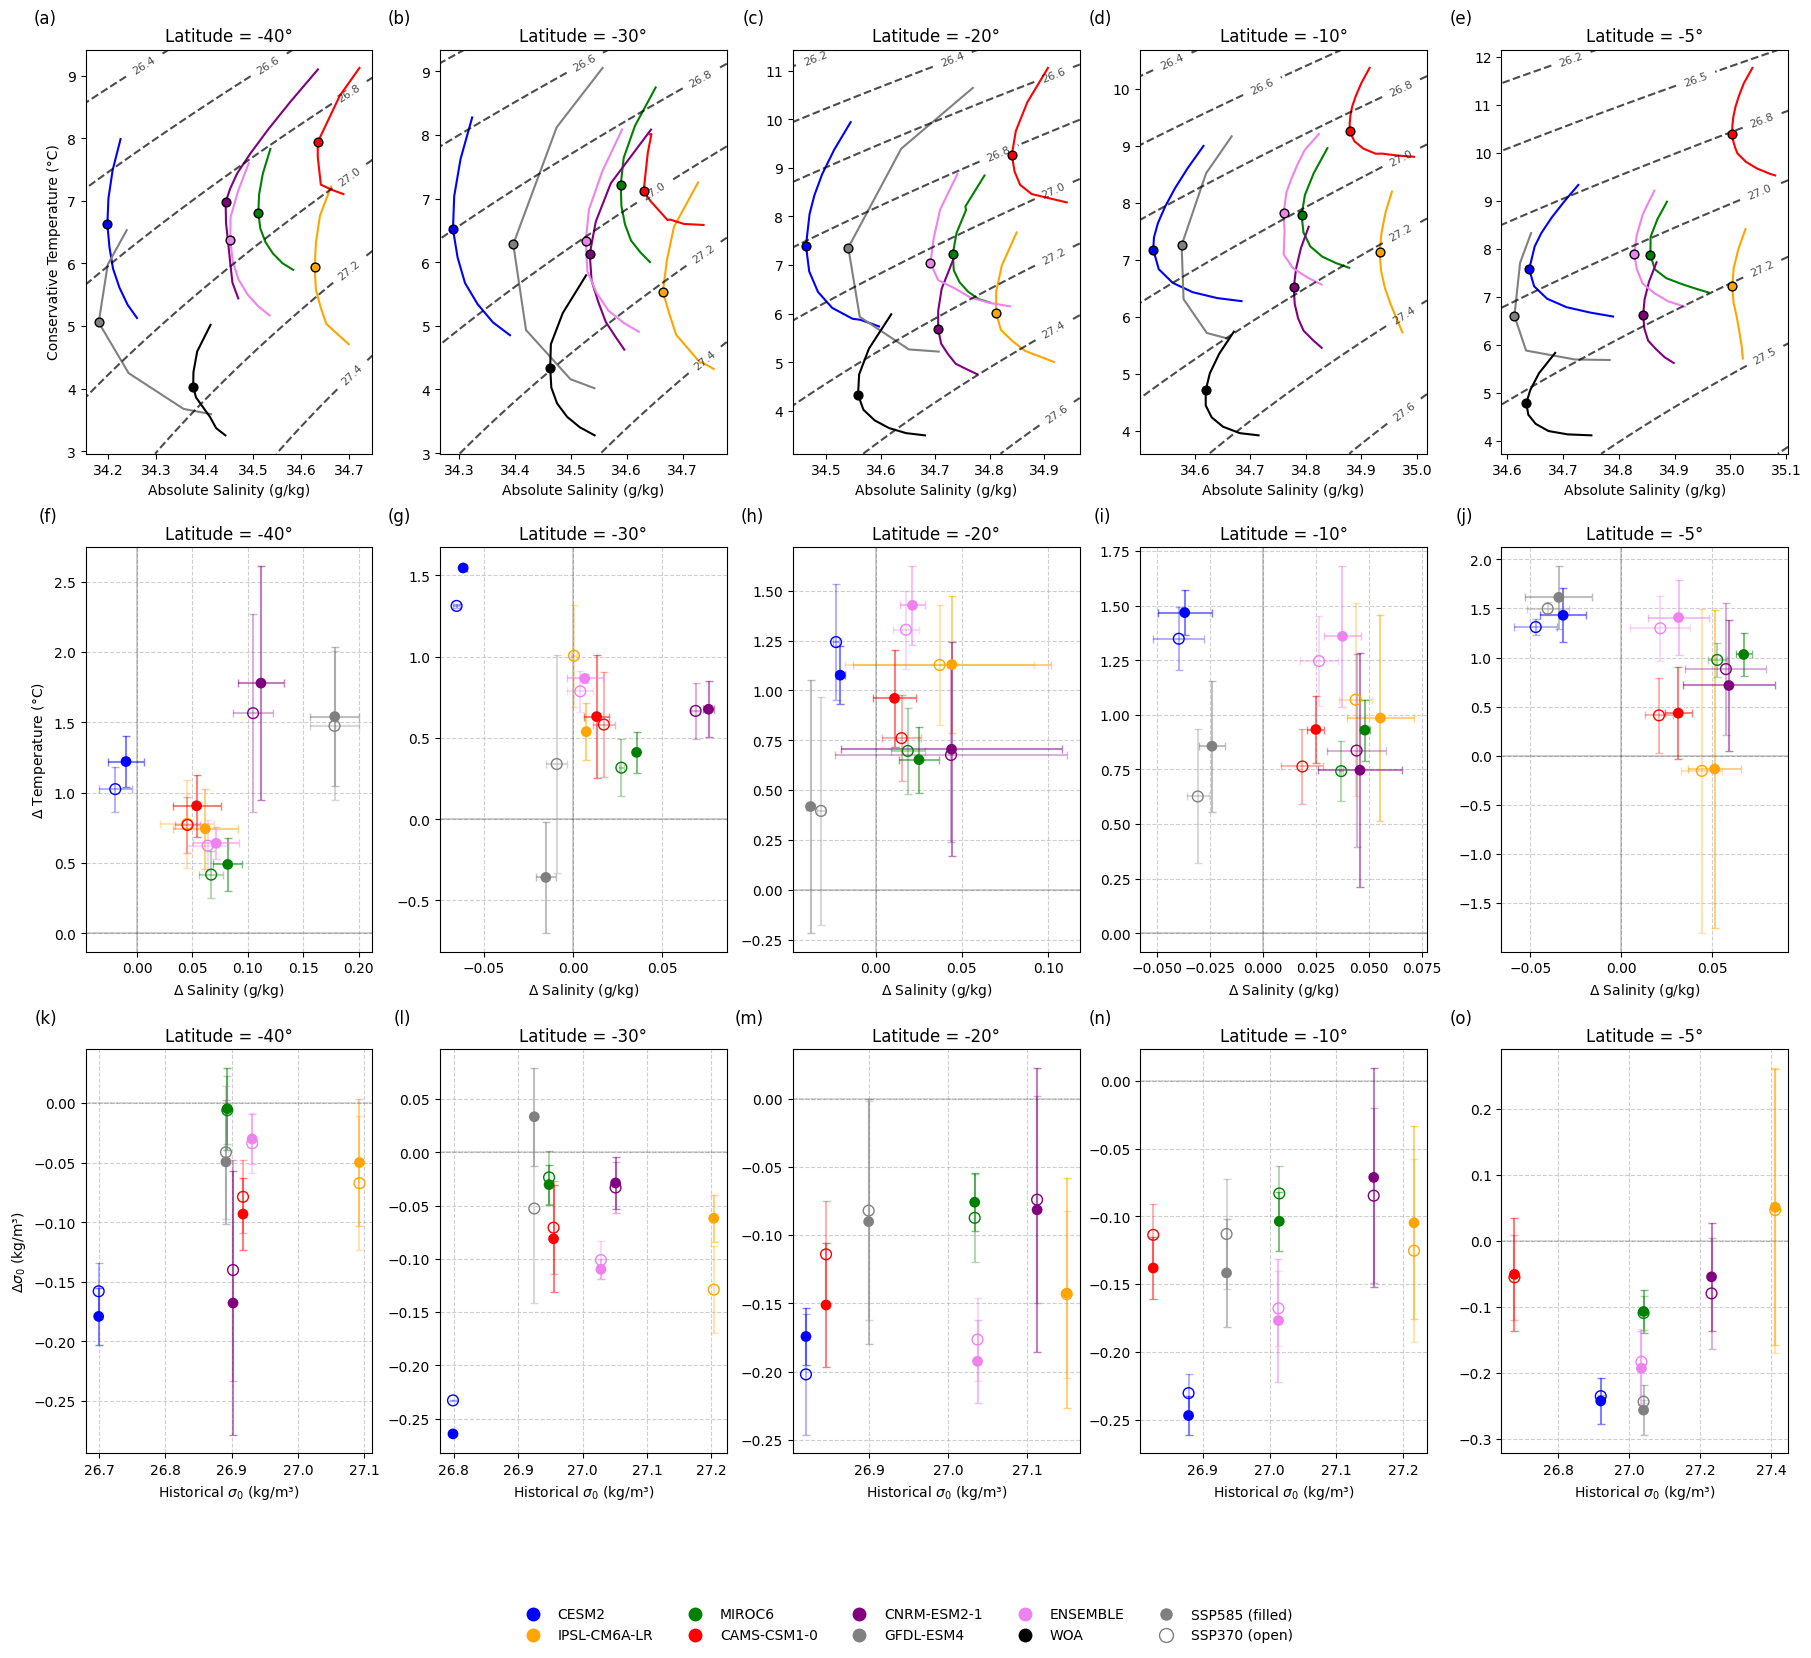

In [14]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import gsw
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Starting variability analysis script...")

# --- 1. Initial Definitions and Paths ---

# Path to new data with longitudinal variability
pasta_dados = '/content/drive/MyDrive/Artigo_AIA/Diferencas_TS/Dados_SSP_e_Hist (Variabilidade)'

# Path to WOA file (used as reference and target grid)
# Assuming the WOA file from the previous script is in the old path
caminho_woa = '/content/drive/MyDrive/Artigo_AIA/Diferencas_TS/Dados_SSP_e_Hist/woa_1981_2010.nc'

# Folder to save the final figure
pasta_resultados = '/content/drive/MyDrive/Artigo_AIA/Diferencas_TS/Resultados_Variabilidade'
os.makedirs(pasta_resultados, exist_ok=True)

# Latitudes of interest
latitudes_desejadas = [-40, -30, -20, -10, -5]

# Depth levels for interpolation (focus on AAIW)
levels_interp = np.arange(100, 1500, 5) # Using 5m step to be faster

# Models to process (without WOA and ENSEMBLE for now)
modelos = ['CESM2', 'IPSL-CM6A-LR', 'MIROC6', 'CAMS-CSM1-0', 'CNRM-ESM2-1', 'GFDL-ESM4']

# Plotting definitions
cores_modelos = {
    'CESM2' : 'blue',
    'IPSL-CM6A-LR': 'orange',
    'MIROC6': 'green',
    'CAMS-CSM1-0': 'red',
    'CNRM-ESM2-1': 'purple',
    'GFDL-ESM4': 'gray',
    'WOA': 'black',
    'ENSEMBLE' : 'violet'
}
s = 60 # Marker size

# --- 2. Helper Functions ---

def encontrar_arquivo_cenario(modelo_nome, cenario, pasta):
    """Finds the file for a specific model and scenario."""

    # Defines the correct prefix based on the scenario
    if cenario == 'historical':
        prefixo = 'CMIP'
    else: # ssp585, ssp370, etc.
        prefixo = 'ScenarioMIP'

    # The search pattern now uses the correct prefix and model name
    # The pattern is: {Prefix}.{Institution}.{Modelo}.{Cenário}.*.nc
    # We use '*' for {Institution} as it varies (e.g., CAMS, NCAR, NOAA-GFDL)
    padrao_busca = os.path.join(pasta, f"{prefixo}.*.{modelo_nome}.{cenario}.*.nc")

    arquivos_encontrados = glob.glob(padrao_busca)

    if not arquivos_encontrados:
        print(f"WARNING: No file found for {modelo_nome} - {cenario} with pattern {padrao_busca}")
        return None

    # Returns the first file found
    return arquivos_encontrados[0]

def regrid_to_target(ds, target_ds):
    """Interpolates a dataset (ds) to the grid (lat, lon) of another (target_ds)."""
    target_lats = target_ds['lat']
    target_lons = target_ds['lon']

    # Handles different coordinate names (e.g., 'latitude' vs 'lat')
    if 'latitude' in ds.coords:
        ds = ds.rename({'latitude': 'lat'})
    if 'longitude' in ds.coords:
        ds = ds.rename({'longitude': 'lon'})

    # Ensures longitudes are 0-360 or -180-180 (here we go to 0-360)
    ds['lon'] = (ds['lon'] + 360) % 360
    target_lons = (target_lons + 360) % 360

    ds = ds.sortby('lon')
    target_ds = target_ds.sortby('lon')

    return ds.interp(lat=target_lats, lon=target_lons, method='linear')

def calcular_propriedades_sal_min(ds):
    """
    Calculates the salinity minimum and associated properties
    in a 3D dataset (lev, lat, lon).
    Returns a new 2D dataset (lat, lon).
    Handles land points (all-NaN profiles) by filling with a high value.
    """

    # 1. Fill NaNs (land) with a very high value (e.g., 99999)
    #    so that argmin does not fail. We use fillna()
    sa_filled = ds['sa'].fillna(99999)

    # 2. Finds the depth index (lev) where salinity is minimum
    #    It no longer fails, as there are no "all-NaN" profiles
    #    We use skipna=False as there are no problematic NaNs.
    idxmin_lev = sa_filled.argmin(dim='lev', skipna=False)

    # 3. Gets the values at that index USING THE ORIGINAL DATASETS
    #    On land points, idxmin_lev will be 0, and the selected values
    #    will be the original ones (i.e., np.nan), which is correct.
    sa_min = ds['sa'].isel(lev=idxmin_lev)
    thetao_at_sa_min = ds['thetao'].isel(lev=idxmin_lev)
    lev_at_sa_min = ds['lev'].isel(lev=idxmin_lev)

    # Calculate sigma0 (gsw handles NaNs well)
    sigma0_at_sa_min = gsw.sigma0(sa_min, thetao_at_sa_min)

    # Rename for clarity
    sa_min = sa_min.rename('sa_min')
    thetao_at_sa_min = thetao_at_sa_min.rename('thetao_min')
    lev_at_sa_min = lev_at_sa_min.rename('lev_min')
    sigma0_at_sa_min = sigma0_at_sa_min.rename('sigma_min')

    # Returns a dataset with all properties
    return xr.merge([sa_min, thetao_at_sa_min, lev_at_sa_min, sigma0_at_sa_min])

def calcular_estatisticas_por_latitude(diff_ds, hist_ds, latitudes):
    """
    Calculates mean, standard deviation, and p-value (t-test) along longitude
    for each latitude of interest.
    """
    resultados = []
    for lat in latitudes:
        # Selects the nearest latitude
        diff_at_lat = diff_ds.sel(lat=lat, method='nearest')
        hist_at_lat = hist_ds.sel(lat=lat, method='nearest')

        # Loop over variables of interest
        for var_name in ['sa_min', 'thetao_min', 'lev_min', 'sigma_min']:

            # Difference data (1D along lon)
            diff_data = diff_at_lat[var_name].dropna(dim='lon')

            # Historical data (1D along lon)
            hist_data = hist_at_lat[var_name].dropna(dim='lon')

            # Calculate statistics of the DIFFERENCE
            mean_diff = diff_data.mean().values
            std_diff = diff_data.std().values

            # 1-sample t-test (is the mean difference sig. different from 0?)
            # Ignores if there is little data (ex: all-NaN)
            if len(diff_data) > 2:
                t_stat, p_value = stats.ttest_1samp(diff_data, 0)
            else:
                p_value = np.nan

            # Calculate statistics for HISTORICAL (for the X-axis of the sigma plot)
            mean_hist = hist_data.mean().values
            std_hist = hist_data.std().values

            # Store
            resultados.append({
                'Latitude': lat,
                'Variavel': var_name,
                'mean_diff': mean_diff,
                'std_diff': std_diff,
                'p_value': p_value,
                'mean_hist': mean_hist,
                'std_hist': std_hist
            })

    df = pd.DataFrame(resultados).set_index(['Latitude', 'Variavel'])
    return df

# --- 3. Data Loading and Processing ---

print("Loading WOA reference file for the grid...")
ds_woa_raw = xr.open_dataset(caminho_woa, decode_times=False).isel(time=0)
if 'depth' in ds_woa_raw.coords:
    ds_woa_raw = ds_woa_raw.rename({'depth': 'lev'})
if 'c_t' in ds_woa_raw.data_vars:
     ds_woa_raw = ds_woa_raw.rename({'c_t': 'thetao'}) # Rename T_cons to thetao
if 'a_s' in ds_woa_raw.data_vars:
     ds_woa_raw = ds_woa_raw.rename({'a_s': 'sa'}) # Rename S_abs to sa

# Process WOA (interpolate depth)
ds_woa_proc = ds_woa_raw.interp(lev=levels_interp, method="linear")

# Dictionaries to store all processed data
all_model_data = {}
all_hist_ds_regridded = []
all_ssp585_ds_regridded = []
all_ssp370_ds_regridded = []

print(f"Starting processing for {len(modelos)} models...")

for modelo in modelos:
    print(f"Processing: {modelo}")
    try:
        # Find paths
        f_hist = encontrar_arquivo_cenario(modelo, 'historical', pasta_dados)
        f_ssp585 = encontrar_arquivo_cenario(modelo, 'ssp585', pasta_dados)
        f_ssp370 = encontrar_arquivo_cenario(modelo, 'ssp370', pasta_dados)

        if not all([f_hist, f_ssp585, f_ssp370]):
            print(f"Skipping {modelo} due to missing files.")
            continue

        # Load datasets (time mean removed, as they are already climatologies)
        ds_hist = xr.open_dataset(f_hist, use_cftime=True)
        ds_ssp585 = xr.open_dataset(f_ssp585, use_cftime=True)
        ds_ssp370 = xr.open_dataset(f_ssp370, use_cftime=True)

        # Regrid (interpolate) to WOA grid
        # This step solves the GFDL problem
        print(f"  Regridding {modelo} to WOA grid...")
        ds_hist_regrid = regrid_to_target(ds_hist, ds_woa_raw)
        ds_ssp585_regrid = regrid_to_target(ds_ssp585, ds_woa_raw)
        ds_ssp370_regrid = regrid_to_target(ds_ssp370, ds_woa_raw)

        # Store for ENSEMBLE calculation
        all_hist_ds_regridded.append(ds_hist_regrid)
        all_ssp585_ds_regridded.append(ds_ssp585_regrid)
        all_ssp370_ds_regridded.append(ds_ssp370_regrid)


        # Interpolate vertically (depth)
        print(f"  Interpolating {modelo} vertically...")
        ds_hist_proc = ds_hist_regrid.interp(lev=levels_interp, method="linear")
        ds_ssp585_proc = ds_ssp585_regrid.interp(lev=levels_interp, method="linear")
        ds_ssp370_proc = ds_ssp370_regrid.interp(lev=levels_interp, method="linear")

        # Calculate salinity minimum properties (2D datasets: lat, lon)
        print(f"  Calculating S_min properties for {modelo}...")
        props_hist = calcular_propriedades_sal_min(ds_hist_proc)
        props_ssp585 = calcular_propriedades_sal_min(ds_ssp585_proc)
        props_ssp370 = calcular_propriedades_sal_min(ds_ssp370_proc)

        # Calculate differences (2D datasets: lat, lon)
        diff_ssp585 = props_ssp585 - props_hist
        diff_ssp370 = props_ssp370 - props_hist

        # Calculate longitudinal statistics (mean, std, p-value) ONLY FOR THE ENSEMBLE
        # Statistics for individual models will not be used in the plot, but can be kept
        # if the user wants to see it separately.
        print(f"  Calculating longitudinal statistics for {modelo}...")
        stats_ssp585 = calcular_estatisticas_por_latitude(diff_ssp585, props_hist, latitudes_desejadas)
        stats_ssp370 = calcular_estatisticas_por_latitude(diff_ssp370, props_hist, latitudes_desejadas)

        # Save everything in the dictionary
        all_model_data[modelo] = {
            'stats_ssp585': stats_ssp585,
            'stats_ssp370': stats_ssp370,
            'hist_raw_proc': ds_hist_proc # For the TS plot
        }

    except Exception as e:
        print(f"ERROR processing model {modelo}: {e}")
        continue

# --- 4. ENSEMBLE Calculation ---
print("Calculating the ENSEMBLE (Multi-Model Mean)...")

try:
    # Creates the ensemble dataset by averaging over the new 'model' dimension
    ds_hist_ensemble = xr.concat(all_hist_ds_regridded, dim='model').mean(dim='model')
    ds_ssp585_ensemble = xr.concat(all_ssp585_ds_regridded, dim='model').mean(dim='model')
    ds_ssp370_ensemble = xr.concat(all_ssp370_ds_regridded, dim='model').mean(dim='model')

    # Process the ENSEMBLE exactly like an individual model
    ds_hist_ens_proc = ds_hist_ensemble.interp(lev=levels_interp, method="linear")
    ds_ssp585_ens_proc = ds_ssp585_ensemble.interp(lev=levels_interp, method="linear")
    ds_ssp370_ens_proc = ds_ssp370_ensemble.interp(lev=levels_interp, method="linear")


    props_hist_ens = calcular_propriedades_sal_min(ds_hist_ens_proc)
    props_ssp585_ens = calcular_propriedades_sal_min(ds_ssp585_ens_proc)
    props_ssp370_ens = calcular_propriedades_sal_min(ds_ssp370_ens_proc)

    diff_ssp585_ens = props_ssp585_ens - props_hist_ens
    diff_ssp370_ens = props_ssp370_ens - props_hist_ens

    # Calculate longitudinal statistics (mean, std, p-value)
    stats_ssp585_ens = calcular_estatisticas_por_latitude(diff_ssp585_ens, props_hist_ens, latitudes_desejadas)
    stats_ssp370_ens = calcular_estatisticas_por_latitude(diff_ssp370_ens, props_hist_ens, latitudes_desejadas)

    # Add to the data dictionary
    all_model_data['ENSEMBLE'] = {
        'stats_ssp585': stats_ssp585_ens,
        'stats_ssp370': stats_ssp370_ens,
        'hist_raw_proc': ds_hist_ens_proc
    }
except Exception as e:
    print(f"ERROR calculating ENSEMBLE: {e}")

# Add WOA to the dictionary for plotting
all_model_data['WOA'] = {
    'hist_raw_proc': ds_woa_proc
}

# Update the list of models to plot to include the new ones
modelos_para_plotar = list(all_model_data.keys())


# --- 5. Plotting ---
print("Starting plotting...")

num_linhas = 3
num_colunas = len(latitudes_desejadas)
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(18, 15), constrained_layout=True)

# --- ROW 1: TS Diagrams ---
print("Plotting Row 1: T-S Diagrams...")
for j, latitude in enumerate(latitudes_desejadas):
    ax_ts = axs[0, j]

    for modelo in modelos_para_plotar:
        if 'hist_raw_proc' not in all_model_data[modelo]:
            continue

        ds = all_model_data[modelo]['hist_raw_proc']
        cor = cores_modelos[modelo]

        # Select latitude and calculate longitudinal MEAN
        ds_lat = ds.sel(lat=latitude, method="nearest")
        sa_mean = ds_lat['sa'].mean(dim='lon')
        thetao_mean = ds_lat['thetao'].mean(dim='lon')

        # Find the index of the minimum salinity IN THE MEAN PROFILE
        min_sal_idx = sa_mean.argmin().values

        # Define depth limits (as in the original code)
        min_depth_idx = max(0, min_sal_idx - 30)
        max_depth_idx = min(len(levels_interp) - 1, min_sal_idx + 50)

        # Filter mean data
        sa_filtered = sa_mean[min_depth_idx:max_depth_idx]
        thetao_filtered = thetao_mean[min_depth_idx:max_depth_idx]

        # Plot the mean T-S profile
        ax_ts.plot(sa_filtered, thetao_filtered, color=cor, label=modelo if j == 0 else "")

        # Plot the mean S_min point
        ax_ts.scatter(sa_mean[min_sal_idx], thetao_mean[min_sal_idx],
                      color=cor, edgecolor='black', zorder=5, s=s-20)

    # T-S plot setup (Density Contours)
    xlim = ax_ts.get_xlim()
    ylim = ax_ts.get_ylim()
    sa_grid, ct_grid = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                                     np.linspace(ylim[0], ylim[1], 100))
    sigma0_grid = gsw.sigma0(sa_grid, ct_grid)

    contornos = ax_ts.contour(sa_grid, ct_grid, sigma0_grid, colors='k', linestyles='dashed', alpha=0.7)
    ax_ts.clabel(contornos, inline=True, fontsize=8, fmt='%1.1f')
    ax_ts.set_xlim(xlim)
    ax_ts.set_ylim(ylim)

    ax_ts.set_title(f"Latitude = {latitude}°")
    ax_ts.set(xlabel='Absolute Salinity (g/kg)')
    if j == 0:
        ax_ts.set(ylabel='Conservative Temperature (°C)')

# --- ROWS 2 and 3: Scatter Plots with Error Bars ---

quantities = ['Temperature and Salinity', 'Sigma0']
models_diff = [m for m in modelos_para_plotar if m != 'WOA'] # WOA has no differences

for i, quantity in enumerate(quantities):
    print(f"Plotting Row {i+2}: {quantity}...")
    for j, latitude in enumerate(latitudes_desejadas):
        ax = axs[i + 1, j]

        for modelo in models_diff:
            cor = cores_modelos[modelo]
            df_585 = all_model_data[modelo]['stats_ssp585'].loc[latitude]
            df_370 = all_model_data[modelo]['stats_ssp370'].loc[latitude]

            if quantity == 'Temperature and Salinity':
                # --- SSP585 (Filled, with error bar) ---
                x_mean = df_585.loc['sa_min', 'mean_diff']
                y_mean = df_585.loc['thetao_min', 'mean_diff']
                x_std = df_585.loc['sa_min', 'std_diff']
                y_std = df_585.loc['thetao_min', 'std_diff']
                # P-value: significant if p < 0.05
                sig = (df_585.loc['sa_min', 'p_value'] < 0.05) and (df_585.loc['thetao_min', 'p_value'] < 0.05)

                ax.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='none', ecolor=cor, alpha=0.5, capsize=3)
                ax.scatter(x_mean, y_mean, marker='o', facecolors=cor,
                           edgecolors='none', # Removed black edge for significance
                           s=s, zorder=10)

                # --- SSP370 (Open, with error bar) ---
                x_mean = df_370.loc['sa_min', 'mean_diff']
                y_mean = df_370.loc['thetao_min', 'mean_diff']
                x_std = df_370.loc['sa_min', 'std_diff']
                y_std = df_370.loc['thetao_min', 'std_diff']
                sig = (df_370.loc['sa_min', 'p_value'] < 0.05) and (df_370.loc['thetao_min', 'p_value'] < 0.05)

                ax.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='none', ecolor=cor, alpha=0.3, capsize=3)
                ax.scatter(x_mean, y_mean, marker='o', facecolors='none',
                           edgecolors=cor,
                           linewidth=1.0, # Removed thicker edge for significance
                           s=s, zorder=9)

                # Axis Setup
                ax.axhline(0, color='k', linestyle='-', linewidth=0.2, alpha=0.2)
                ax.axvline(0, color='k', linestyle='-', linewidth=0.2, alpha=0.2)
                ax.set(xlabel=r'$Δ$ Salinity (g/kg)')
                if j == 0:
                    ax.set(ylabel=r'$Δ$ Temperature (°C)')

            elif quantity == 'Sigma0':
                # --- SSP585 (Filled, with error bar) ---
                x_mean = df_585.loc['sigma_min', 'mean_hist'] # X-axis is the historical value
                y_mean = df_585.loc['sigma_min', 'mean_diff'] # Y-axis is the difference
                x_std = df_585.loc['sigma_min', 'std_hist']
                y_std = df_585.loc['sigma_min', 'std_diff']
                sig = df_585.loc['sigma_min', 'p_value'] < 0.05 # Black edge if the *difference* (Y-axis) is sig.

                ax.errorbar(x_mean, y_mean, xerr=None, yerr=y_std, fmt='none', ecolor=cor, alpha=0.5, capsize=3)
                ax.scatter(x_mean, y_mean, marker='o', facecolors=cor,
                           edgecolors='none', # Removed black edge for significance
                           s=s, zorder=10)

                # --- SSP370 (Open, with error bar) ---
                x_mean = df_370.loc['sigma_min', 'mean_hist']
                y_mean = df_370.loc['sigma_min', 'mean_diff']
                x_std = df_370.loc['sigma_min', 'std_hist']
                y_std = df_370.loc['sigma_min', 'std_diff']
                sig = df_370.loc['sigma_min', 'p_value'] < 0.05

                ax.errorbar(x_mean, y_mean, xerr=None, yerr=y_std, fmt='none', ecolor=cor, alpha=0.3, capsize=3)
                ax.scatter(x_mean, y_mean, marker='o', facecolors='none',
                           edgecolors=cor,
                           linewidth=1.0, # Removed thicker edge for significance
                           s=s, zorder=9)

                # Axis Setup
                ax.axhline(0, color='k', linestyle='--', linewidth=0.2, alpha=0.2)
                ax.set(xlabel=r'Historical $σ_0$ (kg/m³)')
                if j == 0:
                    ax.set(ylabel=r'$Δ σ_0$ (kg/m³)')

            ax.grid(True, linestyle='--', alpha=0.6)
            ax.set_title(f"Latitude = {latitude}°")


# --- 6. Legend and Finalization ---

# Add letters to subplots
letters = string.ascii_lowercase
for i, ax in enumerate(axs.flat):
    ax.text(-0.1, 1.1, f"({letters[i]})", transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right')

# Custom legend
handles_legend = [plt.Line2D([0], [0], marker='o', color='w',
                                   markerfacecolor=cores_modelos[m],
                                   markeredgecolor='none', markersize=10, label=m)
                    for m in modelos_para_plotar if m in cores_modelos]

# Add legend for SSP585 vs SSP370
handles_legend.append(plt.Line2D([0], [0], marker='o', color='w',
                                   markerfacecolor='gray', markersize=10,
                                   label='SSP585 (filled)'))
handles_legend.append(plt.Line2D([0], [0], marker='o', color='w',
                                   markerfacecolor='none', markeredgecolor='gray',
                                   markersize=10, label='SSP370 (open)'))

# Removed legend for significance
# handles_legend.append(plt.Line2D([0], [0], marker='o', color='w',
#                                    markerfacecolor='gray', markeredgecolor='black',
#                                    markersize=10, label='Significant Change (p<0.05)'))


fig.legend(handles=handles_legend, loc='lower center', ncol=5,
           bbox_to_anchor=(0.5, -0.10), fontsize=10, frameon=False)

# Save figure
figure_path = os.path.join(pasta_resultados, "Figure_Variability_Analysis_TS.png")
plt.savefig(figure_path, bbox_inches='tight', dpi=600)

print(f"Figure saved to: {figure_path}")
print("Script finished successfully!")

In [15]:
print("Statistics for the Ensemble - SSP370:")
display(stats_ssp370_ens)

print("\nStatistics for the Ensemble - SSP585:")
display(stats_ssp585_ens)

Statistics for the Ensemble - SSP370:


mean_diff              std_diff       p_value  \
Latitude Variavel                                                               
-40      sa_min       0.06378476595614266    0.0191075932677397  9.384355e-12   
         thetao_min    0.6221803569793701   0.18276569357349115  6.655229e-12   
         lev_min        67.10526315789474     66.16995242463243  3.711270e-07   
         sigma_min     -0.033912287632063  0.025148244891912485  1.164543e-05   
-30      sa_min      0.004111008343417331  0.007375621786167888  4.045825e-02   
         thetao_min    0.7859822212481035   0.12541031213762704  2.866338e-14   
         lev_min      -1.3157894736842106      8.00363490828713  3.238059e-01   
         sigma_min   -0.10114736110833344  0.017686314492029804  1.194514e-13   
-20      sa_min      0.017623444178974195   0.00745368261020234  2.952478e-06   
         thetao_min    1.3042953951236531   0.19569539580303094  2.593559e-11   
         lev_min      -14.473684210526315    22.675905183702746  4.113594e-04   
         sigma_min   -0.17653045555063657   0.03028044079592597  1.245225e-10   
-10      sa_min      0.026477981683733987  0.008823163911177318  8.515681e-06   
         thetao_min     1.246166958411535   0.20731825840728188  2.258485e-08   
         lev_min       -6.578947368421052    16.901621814033064  2.323727e-02   
         sigma_min   -0.16792757290711507  0.027752408293014053  2.130614e-08   
-5       sa_min      0.021567409593230023  0.016583889316912806  3.611095e-03   
         thetao_min    1.2977832102775575    0.3296741928102592  8.822147e-07   
         lev_min      -10.526315789473685    28.464878490505182  3.052432e-02   
         sigma_min   -0.18308235622796473   0.04996347256863316  1.618632e-06   

                              mean_hist              std_hist  
Latitude Variavel                                              
-40      sa_min       34.44577921376249   0.04338472586428512  
         thetao_min   6.441772874395052   0.14552191969698858  
         lev_min     432.89473684210526     318.1518000373972  
         sigma_min    26.93110563062104   0.03164662550108485  
-30      sa_min      34.525147161390386   0.03038161577845563  
         thetao_min  6.1642135692577735    0.4007674973955826  
         lev_min      440.7894736842105      379.031880196094  
         sigma_min   27.028510318714552  0.037602224400426265  
-20      sa_min      34.691120855978625    0.0485898674570942  
         thetao_min  7.0763633358172875   0.17891734234489365  
         lev_min     303.94736842105266    282.93145416554995  
         sigma_min   27.037372770100895   0.05410626952116341  
-10      sa_min       34.74892380052914   0.05894001955504357  
         thetao_min   7.551736293236415    0.6114147707758104  
         lev_min     223.68421052631578    207.66142804589623  
         sigma_min   27.013239627659097   0.04021979023238231  
-5       sa_min       34.82688709762925    0.0998422713226986  
         thetao_min   7.826270161072413    0.5214047975611955  
         lev_min     234.21052631578948     225.1038541481566  
         sigma_min   27.034555127412453    0.0293287326238839


Statistics for the Ensemble - SSP585:


mean_diff              std_diff  \
Latitude Variavel                                                  
-40      sa_min        0.07143829137064266  0.020851686380118545   
         thetao_min     0.6394511497020721   0.11280046054595888   
         lev_min         72.36842105263158     70.42854574248757   
         sigma_min   -0.030234455405877724  0.020676050239589967   
-30      sa_min       0.006622245433425763  0.010101160066491798   
         thetao_min     0.8651030295035419   0.02684230410233302   
         lev_min                       0.0                   0.0   
         sigma_min    -0.10988472464282495  0.009337410644897575   
-20      sa_min       0.021373007132823956  0.007511842935924461   
         thetao_min     1.4267953389730212   0.19825912692040173   
         lev_min       -14.473684210526315    22.675905183702746   
         sigma_min    -0.19244300488521032  0.030289091413619514   
-10      sa_min       0.037571664597704314  0.008620087342207037   
         thetao_min     1.3596533576647443    0.3228891739971288   
         lev_min       -2.6315789473684212    22.790142204853648   
         sigma_min      -0.176939865598888   0.04544087356264383   
-5       sa_min        0.03158605481219538  0.016758459205626866   
         thetao_min     1.4073233048121134    0.3830645172251035   
         lev_min        -7.894736842105263    26.965659910419994   
         sigma_min    -0.19296239637494636   0.05609029837078757   

                          p_value           mean_hist              std_hist  
Latitude Variavel                                                            
-40      sa_min      5.950087e-12   34.44577921376249   0.04338472586428512  
         thetao_min  6.606973e-16   6.441772874395052   0.14552191969698858  
         lev_min     2.879202e-07  432.89473684210526     318.1518000373972  
         sigma_min   4.095769e-06   26.93110563062104   0.03164662550108485  
-30      sa_min      1.848086e-02  34.525147161390386   0.03038161577845563  
         thetao_min  1.438707e-25  6.1642135692577735    0.4007674973955826  
         lev_min              NaN   440.7894736842105      379.031880196094  
         sigma_min   1.374409e-18  27.028510318714552  0.037602224400426265  
-20      sa_min      4.187076e-07  34.691120855978625    0.0485898674570942  
         thetao_min  1.050733e-11  7.0763633358172875   0.17891734234489365  
         lev_min     4.113594e-04  303.94736842105266    282.93145416554995  
         sigma_min   4.548885e-11  27.037372770100895   0.05410626952116341  
-10      sa_min      3.693733e-07   34.74892380052914   0.05894001955504357  
         thetao_min  4.964733e-07   7.551736293236415    0.6114147707758104  
         lev_min     4.868397e-01  223.68421052631578    207.66142804589623  
         sigma_min   9.679246e-07  27.013239627659097   0.04021979023238231  
-5       sa_min      3.118700e-04   34.82688709762925    0.0998422713226986  
         thetao_min  1.583559e-06   7.826270161072413    0.5214047975611955  
         lev_min     8.314878e-02  234.21052631578948     225.1038541481566  
         sigma_min   2.749920e-06  27.034555127412453    0.0293287326238839

In [16]:
# Access the raw difference data for the ensemble
# Note: The raw difference data across longitudes is in diff_ssp370_ens and diff_ssp585_ens
# The stats calculated from this raw data (mean_diff, std_diff, p_value) are in stats_ssp370_ens and stats_ssp585_ens
# We will use stats_ssp370_ens and stats_ssp585_ens as they already contain the calculated statistics

stats_ssp370_ens_data = all_model_data['ENSEMBLE']['stats_ssp370']
stats_ssp585_ens_data = all_model_data['ENSEMBLE']['stats_ssp585']

print("Calculating and displaying statistics for the Ensemble (SSP370):")
resultados_ssp370 = []
for lat in latitudes_desejadas:
    for var_name in ['sa_min', 'thetao_min', 'lev_min', 'sigma_min']:
        # Select the data for the specific latitude and variable
        mean_diff = stats_ssp370_ens_data.loc[(lat, var_name), 'mean_diff']
        std_diff = stats_ssp370_ens_data.loc[(lat, var_name), 'std_diff']
        p_value = stats_ssp370_ens_data.loc[(lat, var_name), 'p_value']

        # Determine if the change is significant (p-value < 0.05)
        is_significant = p_value < 0.05 if not pd.isna(p_value) else False


        resultados_ssp370.append({
            'Latitude': lat,
            'Variavel': var_name,
            'Média da Diferença': mean_diff,
            'Desvio Padrão da Diferença': std_diff,
            'P-value': p_value,
            'Significativo (p<0.05)': is_significant # New column
        })

df_resultados_ssp370 = pd.DataFrame(resultados_ssp370)
display(df_resultados_ssp370)

print("\nCalculating and displaying statistics for the Ensemble (SSP585):")
resultados_ssp585 = []
for lat in latitudes_desejadas:
    for var_name in ['sa_min', 'thetao_min', 'lev_min', 'sigma_min']:
        # Select the data for the specific latitude and variable
        mean_diff = stats_ssp585_ens_data.loc[(lat, var_name), 'mean_diff']
        std_diff = stats_ssp585_ens_data.loc[(lat, var_name), 'std_diff']
        p_value = stats_ssp585_ens_data.loc[(lat, var_name), 'p_value']

        # Determine if the change is significant (p-value < 0.05)
        is_significant = p_value < 0.05 if not pd.isna(p_value) else False

        resultados_ssp585.append({
            'Latitude': lat,
            'Variavel': var_name,
            'Média da Diferença': mean_diff,
            'Desvio Padrão da Diferença': std_diff,
            'P-value': p_value,
            'Significativo (p<0.05)': is_significant # New column
        })

df_resultados_ssp585 = pd.DataFrame(resultados_ssp585)
display(df_resultados_ssp585)

Calculating and displaying statistics for the Ensemble (SSP370):


,Latitude,Variavel,Média da Diferença,Desvio Padrão da Diferença,P-value,Significativo (p<0.05)
0,-40,sa_min,0.06378476595614266,0.0191075932677397,9.384355e-12,True
1,-40,thetao_min,0.6221803569793701,0.18276569357349115,6.655229e-12,True
2,-40,lev_min,67.10526315789474,66.16995242463243,3.711270e-07,True
3,-40,sigma_min,-0.033912287632063,0.025148244891912485,1.164543e-05,True
4,-30,sa_min,0.004111008343417331,0.007375621786167888,4.045825e-02,True
5,-30,thetao_min,0.7859822212481035,0.12541031213762704,2.866338e-14,True
6,-30,lev_min,-1.3157894736842106,8.00363490828713,3.238059e-01,False
7,-30,sigma_min,-0.10114736110833344,0.017686314492029804,1.194514e-13,True
8,-20,sa_min,0.017623444178974195,0.00745368261020234,2.952478e-06,True
9,-20,thetao_min,1.3042953951236531,0.19569539580303094,2.593559e-11,True



Calculating and displaying statistics for the Ensemble (SSP585):


,Latitude,Variavel,Média da Diferença,Desvio Padrão da Diferença,P-value,Significativo (p<0.05)
0,-40,sa_min,0.07143829137064266,0.020851686380118545,5.950087e-12,True
1,-40,thetao_min,0.6394511497020721,0.11280046054595888,6.606973e-16,True
2,-40,lev_min,72.36842105263158,70.42854574248757,2.879202e-07,True
3,-40,sigma_min,-0.030234455405877724,0.020676050239589967,4.095769e-06,True
4,-30,sa_min,0.006622245433425763,0.010101160066491798,1.848086e-02,True
5,-30,thetao_min,0.8651030295035419,0.02684230410233302,1.438707e-25,True
6,-30,lev_min,0.0,0.0,NaN,False
7,-30,sigma_min,-0.10988472464282495,0.009337410644897575,1.374409e-18,True
8,-20,sa_min,0.021373007132823956,0.007511842935924461,4.187076e-07,True
9,-20,thetao_min,1.4267953389730212,0.19825912692040173,1.050733e-11,True


In [17]:
# Access the raw difference data for the ensemble from all_model_data
# Note: The raw difference data across longitudes is in diff_ssp370_ens and diff_ssp585_ens
# The stats calculated from this raw data (mean_diff, std_diff, p_value) are in stats_ssp370_ens and stats_ssp585_ens
# We will use stats_ssp370_ens and stats_ssp585_ens as they already contain the calculated statistics

stats_ssp370_ens_raw_ds = all_model_data['ENSEMBLE']['stats_ssp370'] # This was a DataFrame of stats, not raw diff. Need to get the raw diff DataArray from the previous processing step.
stats_ssp585_ens_raw_ds = all_model_data['ENSEMBLE']['stats_ssp585'] # This was a DataFrame of stats, not raw diff. Need to get the raw diff DataArray from the previous processing step.

# Re-calculate or access the raw diff DataArrays.
# Assuming the raw diff DataArrays are still available in memory from the previous run of YXhovFI29sd8
# If not, we would need to re-calculate them from the re-gridded ensemble datasets:
# ds_hist_ens_proc, ds_ssp370_ens_proc, ds_ssp585_ens_proc
# And then calculate:
# props_hist_ens = calcular_propriedades_sal_min(ds_hist_ens_proc)
# props_ssp370_ens = calcular_propriedades_sal_min(ds_ssp370_ens_proc)
# props_ssp585_ens = calcular_propriedades_sal_min(ds_ssp585_ens_proc)
# diff_ssp370_ens = props_ssp370_ens - props_hist_ens
# diff_ssp585_ens = props_ssp585_ens - props_hist_ens

# For now, let's assume the raw diff DataArrays are available from the last execution context
# If the kernel was restarted or the variables were overwritten, this might fail.
# A more robust approach would be to re-calculate them here if they are not found.

try:
    # Attempt to access the raw diff DataArrays (assuming they are still in the environment)
    # These would have been created inside the try block for ENSEMBLE calculation in YXhovFI29sd8
    diff_ssp370_ens_raw = diff_ssp370_ens # Access the variable directly
    diff_ssp585_ens_raw = diff_ssp585 # Access the variable directly

    # Select the desired latitudes and convert to pandas DataFrame
    print("Creating DataFrame with longitudinal differences for the Ensemble (SSP370):")
    diff_ssp370_latitudes = diff_ssp370_ens_raw.sel(lat=latitudes_desejadas, method='nearest')
    df_diff_ssp370 = diff_ssp370_latitudes.to_dataframe().unstack('lat') # Unstack to have latitudes as columns
    # Drop the unwanted columns, handling potential missing 'member_id'
    cols_to_drop_ssp370 = ['time', 'lev']
    df_diff_ssp370 = df_diff_ssp370.drop(columns=[col for col in cols_to_drop_ssp370 if col in df_diff_ssp370.columns])
    # Transpose the DataFrame
    df_diff_ssp370 = df_diff_ssp370.T
    display(df_diff_ssp370)


    print("\nCreating DataFrame with longitudinal differences for the Ensemble (SSP585):")
    diff_ssp585_latitudes = diff_ssp585_ens_raw.sel(lat=latitudes_desejadas, method='nearest')
    df_diff_ssp585 = diff_ssp585_latitudes.to_dataframe().unstack('lat') # Unstack to have latitudes as columns
     # Drop the unwanted columns, handling potential missing 'member_id'
    cols_to_drop_ssp585 = ['time', 'member_id', 'lev']
    df_diff_ssp585 = df_diff_ssp585.drop(columns=[col for col in cols_to_drop_ssp585 if col in df_diff_ssp585.columns])
    # Transpose the DataFrame
    df_diff_ssp585 = df_diff_ssp585.T
    display(df_diff_ssp585)

except NameError:
    print("Variables 'diff_ssp370_ens' or 'diff_ssp585_ens' not found. Recalculating...")

    # Recalculate the raw diff DataArrays if they are not found
    # Access the processed historical and scenario ensemble datasets
    ds_hist_ens_proc = all_model_data['ENSEMBLE']['hist_raw_proc']

    # Re-open and process the re-gridded ensemble datasets to get props
    # This might be redundant if they are already in memory, but safer if the kernel state is uncertain.
    # A better approach might be to store props_hist_ens, props_ssp370_ens, props_ssp585_ens
    # in all_model_data['ENSEMBLE'] in the previous cell.
    # For now, let's assume the re-gridded datasets are accessible to recalculate props.
    # We need the re-gridded datasets for the ensemble, not just the processed ones.
    # Let's try accessing the re-gridded ones first. This might require re-running the previous cell or restructuring.

    # Assuming all_hist_ds_regridded, all_ssp585_ds_regridded, all_ssp370_ds_regridded are available
    # If not, the user would need to re-run the previous cell to generate them.
    try:
        ds_hist_ensemble = xr.concat(all_hist_ds_regridded, dim='model').mean(dim='model')
        ds_ssp585_ensemble = xr.concat(all_ssp585_ds_regridded, dim='model').mean(dim='model')
        ds_ssp370_ensemble = xr.concat(all_ssp370_ds_regridded, dim='model').mean(dim='model')

        ds_hist_ens_proc = ds_hist_ensemble.interp(lev=levels_interp, method="linear")
        ds_ssp585_ens_proc = ds_ssp585_ensemble.interp(lev=levels_interp, method="linear")
        ds_ssp370_ens_proc = ds_ssp370_ensemble.interp(lev=levels_interp, method="linear")

        props_hist_ens = calcular_propriedades_sal_min(ds_hist_ens_proc)
        props_ssp585_ens = calcular_propriedades_sal_min(ds_ssp585_ens_proc)
        props_ssp370_ens = calcular_propriedades_sal_min(ds_ssp370_ens_proc)

        diff_ssp370_ens_raw = props_ssp370_ens - props_hist_ens
        diff_ssp585_ens_raw = props_ssp585_ens - props_hist_ens

        # Select the desired latitudes and convert to pandas DataFrame
        print("Creating DataFrame with longitudinal differences for the Ensemble (SSP370):")
        diff_ssp370_latitudes = diff_ssp370_ens_raw.sel(lat=latitudes_desejadas, method='nearest')
        df_diff_ssp370 = diff_ssp370_latitudes.to_dataframe().unstack('lat') # Unstack to have latitudes as columns
        # Drop the unwanted columns, handling potential missing 'member_id'
        cols_to_drop_ssp370 = ['time', 'lev']
        df_diff_ssp370 = df_diff_ssp370.drop(columns=[col for col in cols_to_drop_ssp370 if col in df_diff_ssp370.columns])
        # Transpose the DataFrame
        df_diff_ssp370 = df_diff_ssp370.T
        display(df_diff_ssp370)


        print("\nCreating DataFrame with longitudinal differences for the Ensemble (SSP585):")
        diff_ssp585_latitudes = diff_ssp585_ens_raw.sel(lat=latitudes_desejadas, method='nearest')
        df_diff_ssp585 = diff_ssp585_latitudes.to_dataframe().unstack('lat') # Unstack to have latitudes as columns
         # Drop the unwanted columns, handling potential missing 'member_id'
        cols_to_drop_ssp585 = ['time', 'member_id', 'lev']
        df_diff_ssp585 = df_diff_ssp585.drop(columns=[col for col in cols_to_drop_ssp585 if col in df_diff_ssp585.columns])
        # Transpose the DataFrame
        df_diff_ssp585 = df_diff_ssp585.T
        display(df_diff_ssp585)


    except NameError:
        print("Error: Regridded ensemble variables not found. Please run the previous cell (where the ensemble is calculated) before running this cell.")

Creating DataFrame with longitudinal differences for the Ensemble (SSP370):


lon               -61.0  -60.0  -59.0  -58.0  -57.0  -56.0  -55.0  -54.0  \
           lat                                                             
sa_min     -40.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -30.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -20.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -10.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -5.0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
thetao_min -40.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -30.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -20.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -10.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -5.0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
lev_min    -40.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           -30.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           -20.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           -10.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           -5.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
sigma_min  -40.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -30.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -20.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -10.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -5.0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

lon                    -53.0       -52.0  ...      -33.0       -32.0  \
           lat                            ...                          
sa_min     -40.0    0.038964    0.034206  ...        NaN         NaN   
           -30.0         NaN         NaN  ...   0.008118    0.007710   
           -20.0         NaN         NaN  ...   0.016414    0.015176   
           -10.0         NaN         NaN  ...   0.036651    0.035331   
           -5.0          NaN         NaN  ...   0.040881    0.036702   
thetao_min -40.0    0.696094    0.653696  ...        NaN         NaN   
           -30.0         NaN         NaN  ...   0.764419    0.761233   
           -20.0         NaN         NaN  ...   1.411770    1.395149   
           -10.0         NaN         NaN  ...   1.494579    1.462409   
           -5.0          NaN         NaN  ...   1.526737    1.834741   
lev_min    -40.0  100.000000  100.000000  ...   0.000000    0.000000   
           -30.0    0.000000    0.000000  ...   0.000000    0.000000   
           -20.0    0.000000    0.000000  ... -50.000000  -50.000000   
           -10.0    0.000000    0.000000  ... -50.000000  -50.000000   
           -5.0     0.000000    0.000000  ... -50.000000 -100.000000   
sigma_min  -40.0   -0.065082   -0.060882  ...        NaN         NaN   
           -30.0         NaN         NaN  ...  -0.095459   -0.095290   
           -20.0         NaN         NaN  ...  -0.192725   -0.191303   
           -10.0         NaN         NaN  ...  -0.198129   -0.194985   
           -5.0          NaN         NaN  ...  -0.206506   -0.258209   

lon                   -31.0      -30.0      -29.0      -28.0      -27.0  \
           lat                                                            
sa_min     -40.0        NaN        NaN        NaN        NaN        NaN   
           -30.0   0.007122   0.014900        NaN        NaN        NaN   
           -20.0   0.013750   0.012491   0.011482   0.010442   0.009618   
           -10.0   0.034410   0.032578   0.028975   0.025832   0.023465   
           -5.0    0.032168   0.025889   0.021787   0.018202   0.017320   
thetao_min -40.0        NaN        NaN        NaN        NaN        NaN   
           -30.0   1.286793   0.774403        NaN        NaN        NaN   
           -20.0   1.378406   1.363690   1.353882   1.348027   0.86


Creating DataFrame with longitudinal differences for the Ensemble (SSP585):


lon               -61.0  -60.0  -59.0  -58.0  -57.0  -56.0  -55.0  -54.0  \
           lat                                                             
sa_min     -40.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -30.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -20.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -10.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -5.0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
thetao_min -40.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -30.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -20.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -10.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -5.0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
lev_min    -40.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           -30.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           -20.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           -10.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
           -5.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
sigma_min  -40.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -30.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -20.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -10.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           -5.0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

lon                    -53.0       -52.0  ...       -33.0       -32.0  \
           lat                            ...                           
sa_min     -40.0    0.223970    0.129193  ...         NaN         NaN   
           -30.0         NaN         NaN  ...   -0.014487   -0.018424   
           -20.0         NaN         NaN  ...   -0.033153   -0.035854   
           -10.0         NaN         NaN  ...   -0.014590   -0.019269   
           -5.0          NaN         NaN  ...   -0.010310   -0.016114   
thetao_min -40.0    0.932959    0.635889  ...         NaN         NaN   
           -30.0         NaN         NaN  ...   -0.444216   -0.453848   
           -20.0         NaN         NaN  ...    0.904128    0.865473   
           -10.0         NaN         NaN  ...    0.836462    0.784915   
           -5.0          NaN         NaN  ...    1.841455    1.812413   
lev_min    -40.0  300.000000  300.000000  ...    0.000000    0.000000   
           -30.0    0.000000    0.000000  ...  100.000000  100.000000   
           -20.0    0.000000    0.000000  ...    0.000000    0.000000   
           -10.0    0.000000    0.000000  ...    0.000000    0.000000   
           -5.0     0.000000    0.000000  ... -100.000000 -100.000000   
sigma_min  -40.0    0.063571    0.017027  ...         NaN         NaN   
           -30.0         NaN         NaN  ...    0.044191    0.042449   
           -20.0         NaN         NaN  ...   -0.158149   -0.154132   
           -10.0         NaN         NaN  ...   -0.130713   -0.128168   
           -5.0          NaN         NaN  ...   -0.266726   -0.269819   

lon                    -31.0       -30.0       -29.0       -28.0       -27.0  \
           lat                                                                 
sa_min     -40.0         NaN         NaN         NaN         NaN         NaN   
           -30.0   -0.018210         NaN         NaN         NaN         NaN   
           -20.0   -0.037837   -0.039171   -0.039248   -0.038408   -0.037208   
           -10.0   -0.020739   -0.022234   -0.024485   -0.027001   -0.029624   
           -5.0    -0.026782   -0.037334   -0.045088   -0.050714   -0.054982   
thetao_min -40.0         NaN         NaN         NaN         NaN         NaN   
           -30.0   -0.451031         NaN         NaN         NaN         NaN   


In [18]:
# Define the path to the results folder
pasta_resultados = '/content'

# Define file paths for the DataFrames
caminho_ssp370_csv = os.path.join(pasta_resultados, 'diferencas_longitudinais_ensemble_ssp370.csv')
caminho_ssp585_csv = os.path.join(pasta_resultados, 'diferencas_longitudinais_ensemble_ssp585.csv')

# Save the DataFrames to CSV files
df_diff_ssp370.to_csv(caminho_ssp370_csv)
df_diff_ssp585.to_csv(caminho_ssp585_csv)

print(f"DataFrame SSP370 saved to: {caminho_ssp370_csv}")
print(f"DataFrame SSP585 saved to: {caminho_ssp585_csv}")

DataFrame SSP370 saved to: /content/diferencas_longitudinais_ensemble_ssp370.csv
DataFrame SSP585 saved to: /content/diferencas_longitudinais_ensemble_ssp585.csv
